Import required modules

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import mediapipe as mp
from math import dist, sqrt, pow
import pickle

Set data fetching path

In [2]:
folder=os.path.join("data")

Declare mediapipe variables

In [3]:
mp_hands=mp.solutions.hands
mp_drawing=mp.solutions.drawing_utils
mp_drawing_styles=mp.solutions.drawing_styles
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.7, max_num_hands=1)


Calculate distance between several landmarks

In [4]:
def distance_calculation(temp):
  res=[]
  landmark_set=[(0,8),(0,12),(0,16),(0,20),(0,4),(1,4),(5,8),(9,12),(13,16),(17,20),(8,12),(8,16),(8,20),(4,8),(4,20),(4,12),(4,6),(4,10),(4,14),(4,18)]
  for m,n in landmark_set:
    res.append(dist(temp[m],temp[n]))
  return np.array(res)



Generate a model for image recognition

In [12]:
data={}
for dir in os.listdir(folder):
    img = cv2.imread(os.path.join(folder, dir, '0.jpg'))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results=hands.process(img_rgb)

    if results.multi_hand_landmarks:
      for hand_landmarks in results.multi_hand_landmarks:
         myHand = results.multi_hand_landmarks[0]
         temp={}
         for id, lm in enumerate(myHand.landmark):
            height, width, _ = img.shape
            temp[id]=[lm.x,lm.y]
         temp_y=distance_calculation(temp)
         temp_y/=max(temp_y)
         data[chr(int(dir)+65)]=temp_y

with open('rms_model.pickle', 'wb') as f:
    pickle.dump(data, f)
f.close()
         
      

Loading the model

In [7]:
with open('rms_model.pickle', 'rb') as f:
    model = pickle.load(f)
f.close()

Plotting The curves for each signs 

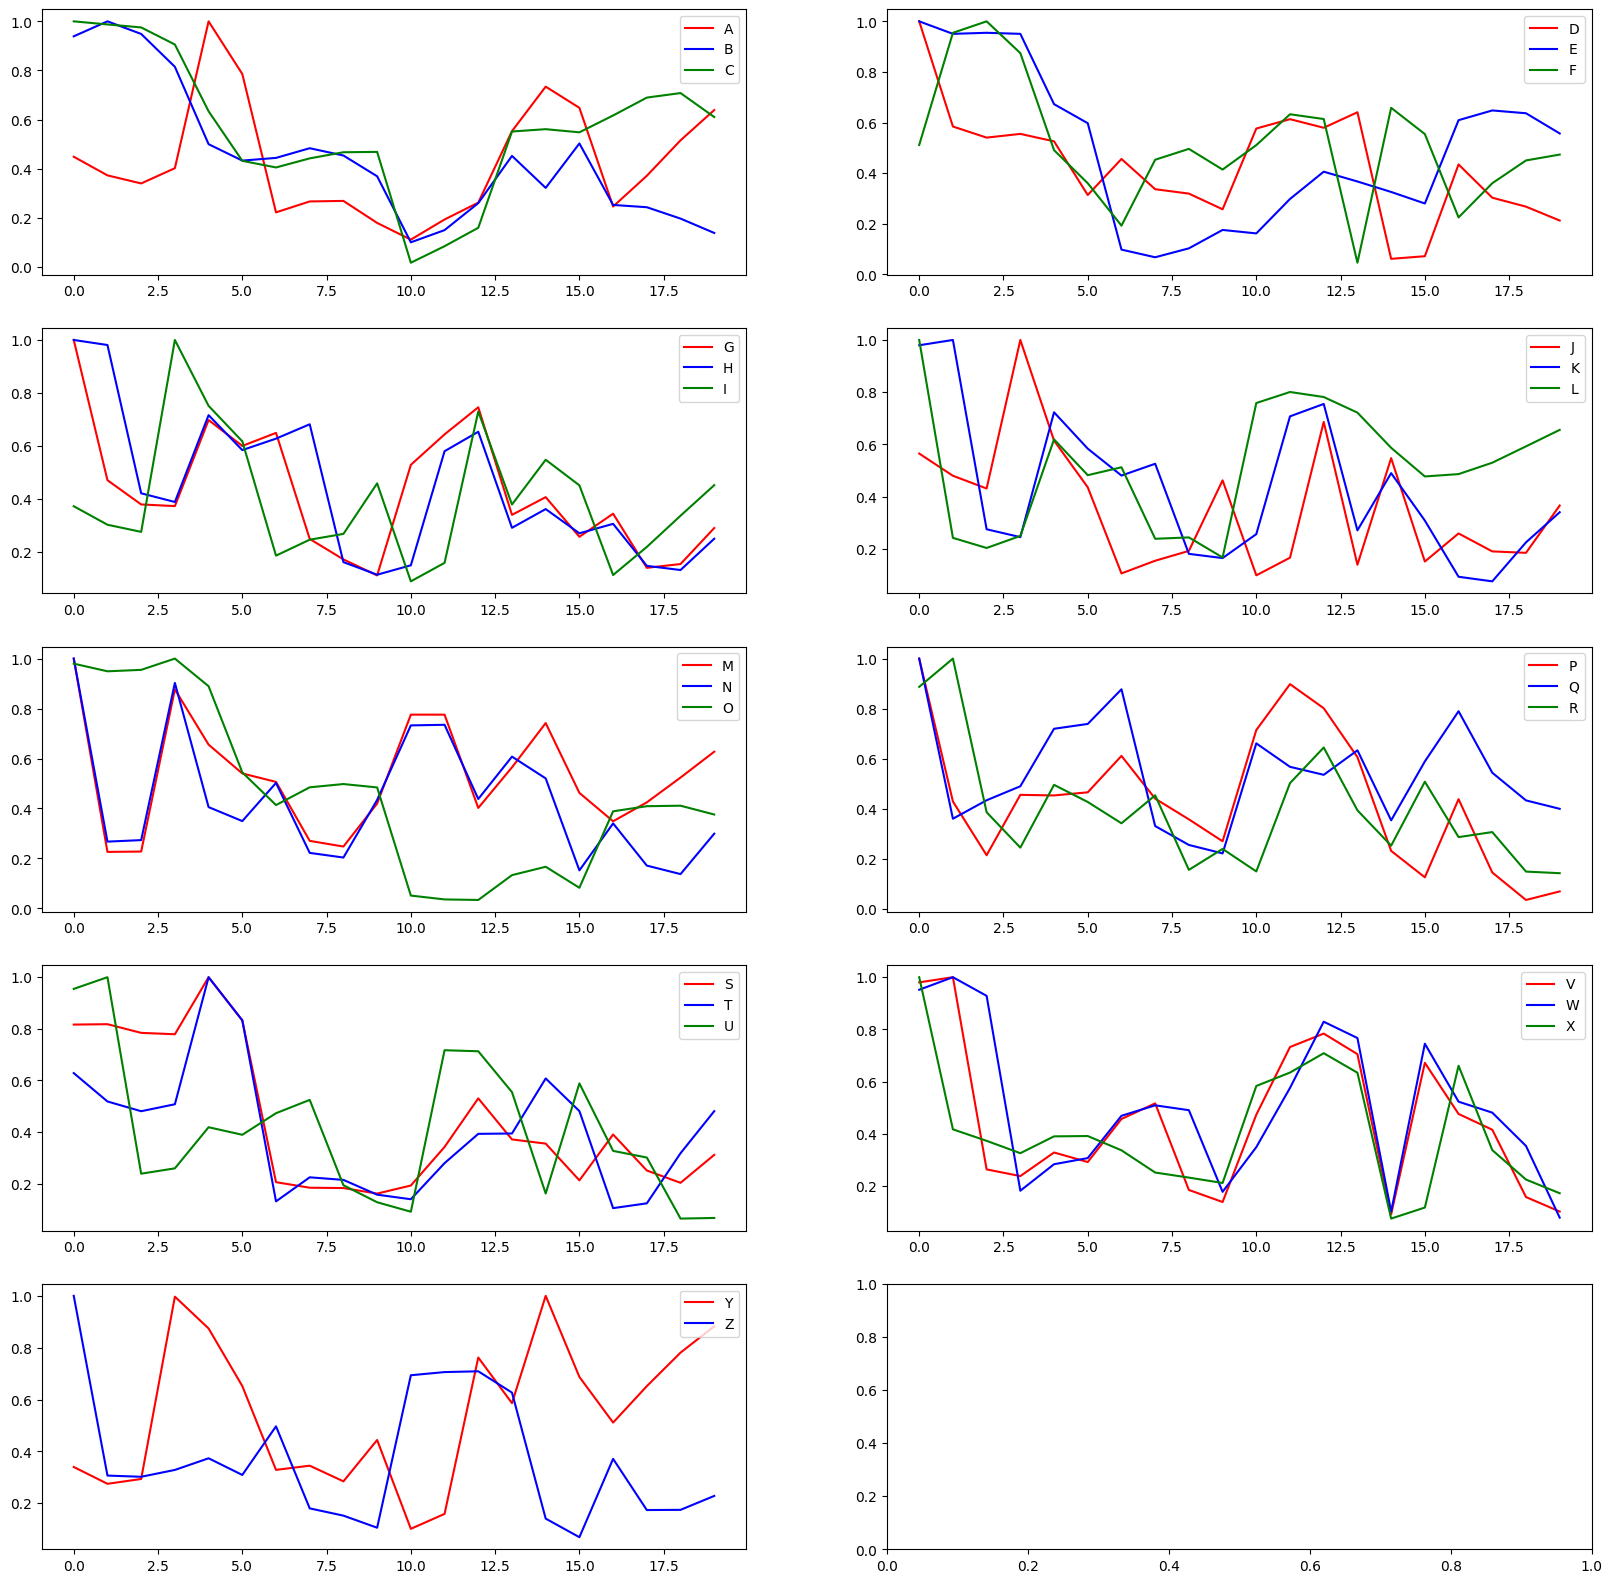

In [8]:
fig,ax=plt.subplots(5,2,figsize=(20,20))
a,b=0,0
for i in range(8):
    l1,l2,l3=chr(65+3*i),chr((65+3*i)+1), chr((65+3*i)+2)
    ax[a][b].plot(model[l1],color="red",label=l1)
    ax[a][b].plot(model[l2],color="blue",label=l2)
    ax[a][b].plot(model[l3],color="green",label=l3)
    ax[a][b].legend(loc='upper right')
    if b==0:
        b=1
    else:
        b=0
        a+=1
ax[4][0].plot(model['Y'],color="red",label='Y')
ax[4][0].plot(model['Z'],color="blue",label='Z')
ax[4][0].legend(loc='upper right')
plt.show()

Calculate RMS value

In [9]:
def rms(a:np.array,b:np.array)->float:
    res=0
    for i in range(20):
        res+=pow(a[i]-b[i],2)
    return sqrt(res)

Function to predict output using the model

In [10]:
def predict(model,test):
    minimum=100.0
    res=''
    for key,value in model.items():
        # print(res)
        rms_=rms(value,test)
        if rms_<minimum:
            res=key
            minimum=rms_
    return res

Capture live feed and show output

In [11]:
cap = cv2.VideoCapture(0)

while True:
    try:
        data_aux = []
        x_ = []
        y_ = []

        _, frame = cap.read()

        # frame_flip=cv2.flip(frame,1)

        H, W, _ = frame.shape

        test_img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        test_results=hands.process(test_img_rgb)

        if test_results.multi_hand_landmarks:
            for hand_landmarks in test_results.multi_hand_landmarks:
                myHand = test_results.multi_hand_landmarks[0]
                temp={}
                for id, lm in enumerate(myHand.landmark):
                    height, width, _ = test_img_rgb.shape
                    temp[id]=[lm.x,lm.y]
                test_temp_y=distance_calculation(temp)
                    # temp_x=np.array([x for x in range(16)])
                test_temp_y/=max(test_temp_y)

        if test_results.multi_hand_landmarks:
            for hand_landmarks in test_results.multi_hand_landmarks:
                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y

                    x_.append(x)
                    y_.append(y)
                    mp_drawing.draw_landmarks(
                            frame, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=1))
        

            x1 = int(min(x_) * W)-10
            y1 = int(min(y_) * H)-10

            x2 = int(max(x_) * W)-10
            y2 = int(max(y_) * H)-10

            x1_rect,y1_rect,x2_rect,y2_rect=x1-50,y1-50,x2+50,y2+50

            

            if x1_rect>0 and x2_rect<W and y1_rect>0 and y2_rect<H:
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 0), 4)
                # crop_img=frame[x1_rect:x2_rect,y1_rect:y2_rect]
                # cv2.imshow('cropped',crop_img)
                
            cv2.putText(frame,predict(model,test_temp_y) , (x1,y1-10), cv2.FONT_ITALIC, 3, (255,204,0), 6,
                        cv2.LINE_AA)

        
        else:
            cv2.putText(frame,'hand out of range' , (0,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 1,
                        cv2.LINE_AA)
            
        cv2.imshow('camera', frame)
        if cv2.waitKey(20) & 0xFF == ord('q'):
            break
    except Exception as e:
        print(e)

cap.release()
cv2.destroyAllWindows()